# Exercícios do Minicurso

## Quadro-resumo dos exercícios

| Notebook               | Título do Exercício                                    | Objetivo Didático                                                                 |
|------------------------|--------------------------------------------------------|-----------------------------------------------------------------------------------|
| `basico.ipynb`         | Municípios prioritários para políticas públicas        | Filtrar e ordenar municípios com base em renda e número de famílias               |
| `joins.ipynb`          | Infos Municípios prioritários para políticas públicas  | Adicionar as informações do município                                             |
| `with_clause.ipynb`    | Mapeamento de famílias vulneráveis por município       | Cruzar tabelas e agregar famílias por município e perfil de instrução e renda     |
| `window_functions.ipynb` | Desigualdade de renda dentro das regiões             | Usar funções de janela para classificar as regiões por desilgualdade              |

---

## Detalhamento dos exercícios

### `basico.ipynb` – Municípios prioritários para políticas públicas

Liste os **10 municípios** onde:
- a **renda média familiar** é inferior a R$ 200, e  
- há mais de 50 famílias cadastradas.

Mostre:
- `cd_ibge`, `renda_media`, `total_familias`  
Ordene do menor para o maior valor médio de renda.

---

### `joins.ipynb` – Infos Municípios prioritários para políticas públicas

Liste os **10 municípios** onde:
- a **renda média familiar** é inferior a R$ 200, e  
- há mais de 50 famílias cadastradas.
- utilize a tabela de informações municípios do IBGE

Mostre:
- `municipio`, `uf`, `regiao`, `total_familias_em_risco`  
Ordene do menor para o maior valor médio de renda.

---

### `with_clause.ipynb` – Mapeamento de famílias vulneráveis por município

Liste os **10 municípios** com o maior número de famílias que:
- possuem **renda média familiar inferior a R$ 200**, e  
- têm **ao menos uma pessoa sem instrução formal** (`cod_curso_frequentou_pessoa_memb`).

Mostre:
- `municipio`, `uf`, `regiao`, `total_familias`  
Ordene pelo maior número de famílias em risco.

---

### `window_functions.ipynb` – Desigualdade de renda dentro das regiões

Calcule a média de renda das famílias por região
- 10% que recebem menos
- 10% que recebem mais
- diferença entre as médias

Mostre:
- `regiao`, `b_10`, `t_10`, `desigualdade`  
Ordene pela maior desigualdade.


# Resolução

In [3]:
from common import DatabaseConnection

conn = DatabaseConnection("database.duckdb")

2025-06-27 23:59:40,518 - INFO - Connected to database: database.duckdb


In [ ]:
conn.execute("""
    SELECT
        *
    FROM familias
    LIMIT 10;
""")

In [ ]:
conn.execute("""
    SELECT
        *
    FROM pessoas
    LIMIT 10;
""")

In [ ]:
conn.execute("""
    SELECT
        *
    FROM ibge_municipios
    LIMIT 10;
""")

# 1 - Municípios prioritários para políticas públicas

In [4]:
conn.execute("""
    SELECT
        cd_ibge,
        AVG(vlr_renda_media_fam) AS renda_media,
        COUNT(*) AS total_familias
    FROM familias
    GROUP BY cd_ibge
    HAVING total_familias > 50 and renda_media < 200
    ORDER BY renda_media
    LIMIT 10;
""")

2025-06-27 23:59:43,874 - INFO - Executing query...


2025-06-27 23:59:44,274 - INFO - Query executed successfully


,cd_ibge,renda_media,total_familias
0,2106409,35.330769,260
1,2201770,36.900000,220
2,2111672,37.950000,100
3,1600550,41.648649,111
4,2701506,43.157895,76
5,2100808,46.441860,258
6,1600105,48.196774,310
7,1600253,50.399293,283
8,2100709,52.162523,1649
9,1506401,54.283019,53


# 2 - Informações dos municípios prioritários para políticas públicas

In [5]:
conn.execute("""
    SELECT
        m."municipio-nome" AS municipio,
        m."UF-sigla" AS uf,
        m."regiao-nome" AS regiao,
        AVG(f.vlr_renda_media_fam) AS renda_media,
        COUNT(f.*) AS total_familias
    FROM familias as f
    JOIN ibge_municipios as m ON f.cd_ibge = m."municipio-id"
    GROUP BY m."municipio-nome", m."UF-sigla", m."regiao-nome"
    HAVING total_familias > 50 and renda_media < 200
    ORDER BY renda_media
    LIMIT 10;
""")

2025-06-28 00:00:02,601 - INFO - Executing query...
2025-06-28 00:00:02,805 - INFO - Query executed successfully


,municipio,uf,regiao,renda_media,total_familias
0,Mata Roma,MA,Nordeste,35.330769,260
1,Boa Hora,PI,Nordeste,36.900000,220
2,São Roberto,MA,Nordeste,37.950000,100
3,Pracuúba,AP,Norte,41.648649,111
4,Campo Grande,AL,Nordeste,43.157895,76
5,Anapurus,MA,Nordeste,46.441860,258
6,Amapá,AP,Norte,48.196774,310
7,Itaubal,AP,Norte,50.399293,283
8,Anajatuba,MA,Nordeste,52.162523,1649
9,Santa Cruz do Arari,PA,Norte,54.283019,53


# 3 - Mapeamento de famílias vulneráveis por município

In [6]:
conn.execute("""
    SELECT
        id_familia,
        id_pessoa,
        CASE
            WHEN cod_curso_frequentou_pessoa_memb = 15 THEN 0
            WHEN cod_curso_frequentou_pessoa_memb is NULL THEN 0
            ELSE 1
        END AS frequentou_curso,
    FROM pessoas
    LIMIT 10;
""")

2025-06-28 00:00:58,195 - INFO - Executing query...
2025-06-28 00:00:58,197 - INFO - Query executed successfully


,id_familia,id_pessoa,frequentou_curso
0,1555504,1,1
1,2151979,2,0
2,5234172,3,1
3,2851256,4,1
4,1230168,5,0
5,3850635,6,0
6,4963019,7,1
7,3407990,8,1
8,1248550,9,0
9,1271681,10,0


In [15]:
conn.execute("""
    WITH frequentou_curso AS (
        SELECT
            id_familia,
            id_pessoa,
            CASE
                WHEN cod_curso_frequentou_pessoa_memb = 15 THEN 0
                WHEN cod_curso_frequentou_pessoa_memb is NULL THEN 0
                ELSE 1
            END AS frequentou_curso,
        FROM pessoas
    )
    SELECT
        m."municipio-nome" AS municipio,
        m."UF-sigla" AS uf,
        m."regiao-nome" AS regiao,
        AVG(f.vlr_renda_media_fam) AS renda_media,
        COUNT(f.*) AS total_familias
    FROM familias AS f
    JOIN frequentou_curso AS fc ON f.id_familia = fc.id_familia
    JOIN ibge_municipios as m ON f.cd_ibge = m."municipio-id"
    WHERE fc.frequentou_curso = 0
    GROUP BY ALL
    HAVING renda_media < 200
    ORDER BY total_familias DESC
    LIMIT 10;
""")

2025-06-28 00:08:06,719 - INFO - Executing query...


2025-06-28 00:08:07,333 - INFO - Query executed successfully


,municipio,uf,regiao,renda_media,total_familias
0,Rio de Janeiro,RJ,Sudeste,139.433983,112668
1,Fortaleza,CE,Nordeste,133.147117,80813
2,Manaus,AM,Norte,137.633275,67721
3,Salvador,BA,Nordeste,120.986583,63877
4,Belém,PA,Norte,113.010662,46056
5,Brasília,DF,Centro-Oeste,141.148774,42178
6,Recife,PE,Nordeste,171.725352,40177
7,São Luís,MA,Nordeste,129.132544,36916
8,Maceió,AL,Nordeste,174.236847,32426
9,Teresina,PI,Nordeste,124.974365,25824


# 4 - Desigualdade de renda entre as regiões

In [8]:
conn.execute("""
    SELECT
        f.vlr_renda_media_fam AS renda,
        m."regiao-nome" AS regiao,
        NTILE(10) OVER (PARTITION BY regiao ORDER BY renda) AS decil
    FROM familias f
    JOIN ibge_municipios m ON f.cd_ibge = m."municipio-id"
    WHERE f.vlr_renda_media_fam IS NOT NULL
    ORDER BY decil
""")

2025-06-28 00:02:29,365 - INFO - Executing query...
2025-06-28 00:02:30,667 - INFO - Query executed successfully


,renda,regiao,decil
0,0,Nordeste,1
1,0,Nordeste,1
2,0,Nordeste,1
3,0,Nordeste,1
4,0,Nordeste,1
...,...,...,...
4807853,2862,Sul,10
4807854,2862,Sul,10
4807855,2862,Sul,10
4807856,2862,Sul,10


In [11]:
conn.execute("""
    WITH renda_decil AS (
        SELECT
            f.vlr_renda_media_fam AS renda,
            m."regiao-nome" AS regiao,
            NTILE(3) OVER (PARTITION BY regiao ORDER BY renda) AS decil
        FROM familias f
        JOIN ibge_municipios m ON f.cd_ibge = m."municipio-id"
        WHERE f.vlr_renda_media_fam IS NOT NULL
    ), media_decil AS (
        SELECT
            regiao,
            AVG(CASE WHEN decil = 1 THEN renda END) AS b_10,
            AVG(CASE WHEN decil = 3 THEN renda END) AS t_10
        FROM renda_decil
        GROUP BY regiao
    )
    SELECT
        regiao,
        ROUND(b_10, 2) AS b_10,
        ROUND(t_10, 2) AS t_10,
        ROUND(t_10 - b_10, 2) AS desigualdade
    FROM media_decil
    ORDER BY desigualdade DESC;
""")

2025-06-28 00:03:28,176 - INFO - Executing query...


2025-06-28 00:03:28,992 - INFO - Query executed successfully


,regiao,b_10,t_10,desigualdade
0,Sul,45.87,841.52,795.65
1,Centro-Oeste,55.34,846.57,791.23
2,Sudeste,23.19,764.63,741.44
3,Norte,19.12,596.41,577.29
4,Nordeste,13.54,567.43,553.89


# Criando Gráficos

2025-06-28 00:03:45,576 - INFO - Executing query...
2025-06-28 00:03:46,281 - INFO - Query executed successfully


,UF,b_7,t_7,desigualdade
0,SC,2.81,1134.03,1131.23
1,MS,10.61,1119.94,1109.33
2,MT,26.89,1133.13,1106.24
3,RS,0.82,1098.91,1098.09
4,PR,9.80,1080.83,1071.03
5,RO,36.81,1107.76,1070.95
6,SP,0.49,1066.28,1065.79
7,TO,13.87,1058.76,1044.89
8,MG,1.49,1039.26,1037.77
9,GO,26.15,1050.47,1024.32


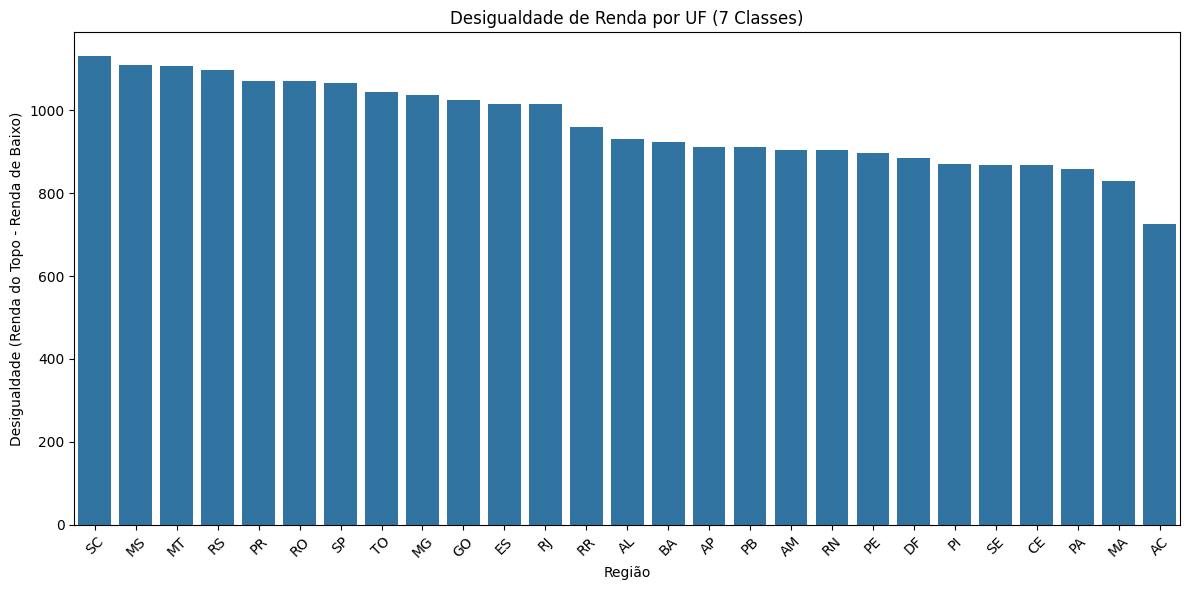

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASSES = 7

desigualdade_df = conn.execute("""
    WITH renda_classe AS (
        SELECT
            f.vlr_renda_media_fam AS renda,
            m."UF-sigla" AS UF,
            NTILE({classes}) OVER (PARTITION BY UF ORDER BY renda) AS classe
        FROM familias f
        JOIN ibge_municipios m ON f.cd_ibge = m."municipio-id"
        WHERE f.vlr_renda_media_fam IS NOT NULL
    ), media_classe AS (
        SELECT
            UF,
            AVG(CASE WHEN classe = 1 THEN renda END) AS b_{classes},
            AVG(CASE WHEN classe = {classes} THEN renda END) AS t_{classes}
        FROM renda_classe
        GROUP BY UF
    )
    SELECT
        UF,
        ROUND(b_{classes}, 2) AS b_{classes},
        ROUND(t_{classes}, 2) AS t_{classes},
        ROUND(t_{classes} - b_{classes}, 2) AS desigualdade
    FROM media_classe
    ORDER BY desigualdade DESC;
""".format(classes=CLASSES))

display(desigualdade_df)

plt.figure(figsize=(12, 6))
sns.barplot(x='UF', y='desigualdade', data=desigualdade_df)
plt.title(f'Desigualdade de Renda por UF ({CLASSES} Classes)')
plt.xlabel('Região')
plt.ylabel('Desigualdade (Renda do Topo - Renda de Baixo)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Salvando Arquivos

In [13]:
CLASSES = 10

conn.execute(f"""
    COPY (
        WITH renda_classe AS (
            SELECT
                f.vlr_renda_media_fam AS renda,
                m."UF-sigla" AS UF,
                NTILE({CLASSES}) OVER (PARTITION BY UF ORDER BY renda) AS classe
            FROM familias f
            JOIN ibge_municipios m ON f.cd_ibge = m."municipio-id"
            WHERE f.vlr_renda_media_fam IS NOT NULL
        ), media_classe AS (
            SELECT
                UF,
                AVG(CASE WHEN classe = 1 THEN renda END) AS b_{CLASSES},
                AVG(CASE WHEN classe = {CLASSES} THEN renda END) AS t_{CLASSES}
            FROM renda_classe
            GROUP BY UF
        )
        SELECT
            UF,
            ROUND(b_{CLASSES}, 2) AS b_{CLASSES},
            ROUND(t_{CLASSES}, 2) AS t_{CLASSES},
            ROUND(t_{CLASSES} - b_{CLASSES}, 2) AS desigualdade
        FROM media_classe
        ORDER BY desigualdade DESC
    ) TO 'desigualdade_renda_uf.csv' WITH (FORMAT CSV, HEADER);
""")

2025-06-28 00:04:42,190 - INFO - Executing query...
2025-06-28 00:04:42,894 - INFO - Query executed successfully


,Count
0,27
